# Part 1: 
In your project you have been working with a bias dataset. Most probabely suupervised models were underfit. You should remember that this is a real dataset, and in real life most of the time you dont have access to clean and unbias dataset. In situations like this, none of the regression models will have a good fit for the dataset due to the large predence of the 0s. In the first part of this take-home exam, you are asked to be creative, and find a solution for this problem. 

For this dataset, you can break the problem, into a two-step machine learning model. 

First step is to classify the data points as positive revenue and zero revenue. This simply is a binary classification. You should remember that when you are dealing with biased datasets, accuracy is not a reliable scoring metric. So look for a robust scoring function. 

Next, you need to build a regression model to postprocess classification results. Here is a flow chart to show you the outline of the model. 

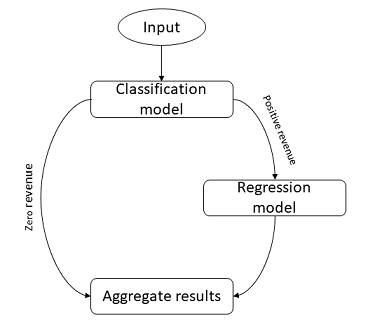

In [1]:
#Importing libraries
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas.io.json as pdjson
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.naive_bayes import GaussianNB 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Parsing the data - since we have JSON columns but with single quotes 
#I have used ast library to fetch the data in these columng
def data_fetch(csv_path, nrows=None):

    JSON_COLUMNS = ['device', 'geoNetwork', 'trafficSource']

    df = pd.read_csv(csv_path, 
                     converters={column: ast.literal_eval for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    device_list=df['device'].tolist()
    
    #deleting unwanted columns before normalizing
    for device in device_list:
        del device['browserVersion'],device['browserSize'],device['flashVersion'],device['mobileInputSelector'],device['operatingSystemVersion'],device['screenResolution'],device['screenColors']
    df['device']=pd.Series(device_list)
    geoNetwork_list=df['geoNetwork'].tolist()
    for network in geoNetwork_list:
        del network['latitude'],network['longitude'],network['networkLocation'],network['cityId']
    df['geoNetwork']=pd.Series(geoNetwork_list)
    
    df['hits']=df['hits'].apply(ast.literal_eval)
    df['hits']=df['hits'].str[0]
    df['hits']=df['hits'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
    
    df['customDimensions']=df['customDimensions'].apply(ast.literal_eval)
    df['customDimensions']=df['customDimensions'].str[0]
    df['customDimensions']=df['customDimensions'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
    
    JSON_COLUMNS = ['device', 'geoNetwork', 'trafficSource','hits','customDimensions']
    for column in JSON_COLUMNS:
        column_as_df = pdjson.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
    return df

In [77]:
df = data_fetch("data.csv")

In [78]:
#Deleting columns that have constant values
#First identifying these columns and then deleting them
for col in df.columns:
    try:
        if (df[col].nunique(dropna=False) == 1):
            del(df[col])
            print(col)
    except TypeError:
        a=df[col].astype('str')
        if (a.nunique(dropna=False) == 1):
            del(df[col])
            print(col)
del(col)

#Removing some json columns with less relevance
df = df.drop(labels=['hits_product'], axis=1)
df = df.drop(labels=['hits_promotion'], axis=1)

#Filling missing data with 0
df['totals_transactionRevenue'].fillna(0, inplace=True)
df['totals_pageviews'].fillna(1, inplace=True)
df['totals_newVisits'].fillna(0, inplace=True) 
df['totals_bounces'].fillna(0, inplace=True)  
df["totals_transactionRevenue"] = df["totals_transactionRevenue"].fillna(0.0) 
df['trafficSource_isTrueDirect'].fillna(False, inplace=True) 
df['trafficSource_adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
df.loc[df['geoNetwork_city'] == "(not set)", 'geoNetwork_city'] = np.nan
df['geoNetwork_city'].fillna("NaN", inplace=True)

df['visitNumber'].fillna(0, inplace=True)
df['visitStartTime'].fillna(0, inplace=True)
df['totals_hits'].fillna(0, inplace=True)
df['totals_sessionQualityDim'].fillna(0, inplace=True)
df['totals_timeOnSite'].fillna(0, inplace=True)
df['totals_transactions'].fillna(0, inplace=True)

df = df.drop('totals_totalTransactionRevenue', axis=1)

socialEngagementType
totals_visits
device_language
device_mobileDeviceBranding
device_mobileDeviceInfo
device_mobileDeviceMarketingName
device_mobileDeviceModel
trafficSource_adwordsClickInfo.criteriaParameters
hits_index
hits_value


#### Adding a column Purchase as 0 for Revenue equal to 0 and 1 for Revenue greater than 0

In [79]:
#Adding a column purchase 
df['Purchase'] = 0
df.loc[df['totals_transactionRevenue'] > 0, 'Purchase'] = 1

#### Creating dummy variables

In [80]:
columns = ['channelGrouping','device_browser','device_deviceCategory','geoNetwork_city',]
df = pd.get_dummies(df, columns=columns)

In [81]:
df[df['Purchase'] == 1].shape

(193, 287)

In [82]:
df[df['Purchase'] == 0].shape

(19807, 287)

In [83]:
#Taking a subset of the data with only continuous/discrete data
df_num_total = df.select_dtypes(include = ['float','int32','int64','float64','float32','uint8','int8'])
X_1 = df_num_total.drop('totals_transactionRevenue', axis=1)
X_1 = X_1.drop(['visitId','Purchase'],axis=1)

y_1 = df['Purchase']

In [84]:
#Splitting into train and test
from sklearn.model_selection import train_test_split

Xtrain_1, Xtest_1, ytrain_1, ytest1_t = train_test_split(X_1, y_1, random_state=1)

In [11]:
from sklearn.svm import SVC
svm = SVC(gamma='auto')
svm.fit(Xtrain_1, ytrain_1) 
ypred_1 = svm.predict(Xtest_1)

Confusion matrix:
 [[4951    0]
 [  49    0]]


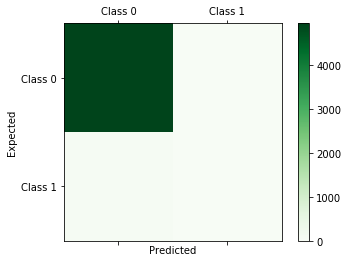

In [170]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=ytest1_t, y_pred=ypred_1)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Greens)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#### Since this does not give us good results lets resample to data in order to train it better

#### Resampling the data - Undersampling & Oversampling to get even number of 1 & 0

In [85]:
df_0 = df[df['Purchase'] == 0]
df_1 = df[df['Purchase'] == 1]

In [86]:
#Putting the value of number of rows into variables
count_1 = df_1.shape[0]
count_0 = df_0.shape[0]

In [87]:
count_0

19807

In [88]:
count_1

193

In [89]:
193/0.4

482.5

In [90]:
483-193

290

#### Oversampling

1    19807
0    19807
Name: Purchase, dtype: int64


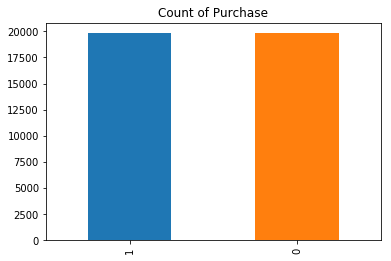

In [91]:
df_1_over = df_1.sample(count_0, replace=True)
df_over = pd.concat([df_0, df_1_over], axis=0)

print(df_over.Purchase.value_counts())

df_over.Purchase.value_counts().plot(kind='bar', title='Count of Purchase');

#### Oversampling the data did not provide very good results thus using the undersampling technique

#### Undersampling

#### Taking 60:40 ratio

In [130]:
df_0_under = df_0.sample(289)
df_1_under = df_1.sample(193)
df_under = pd.concat([df_0_under, df_1_under], axis=0)


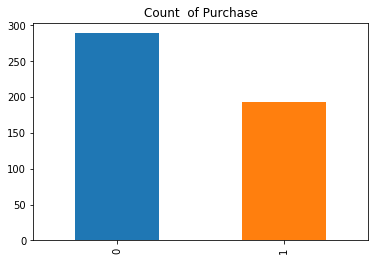

In [131]:
df_under.Purchase.value_counts().plot(kind='bar', title='Count  of Purchase');

#### Training data on under sampled data

In [132]:
#Taking a subset of the data with only continuous/discrete data
df_num = df_under.select_dtypes(include = ['float','int32','int64','float64','float32','uint8','int8'])
Xtrain = df_num.drop('totals_transactionRevenue', axis=1)
Xtrain = Xtrain.drop(['visitId','Purchase'],axis=1)
Xtrain.shape

(482, 207)

In [133]:
#Taking only the target variable
ytrain = df_under['Purchase']
ytrain.shape

(482,)

#### Testing dataset

In [96]:
#Taking a subset of the data with only continuous/discrete data
df_num_test = df.select_dtypes(include = ['float','int32','int64','float64','float32','uint8','int8'])
Xtest = df_num_test.drop('totals_transactionRevenue', axis=1)
Xtest = Xtest.drop(['visitId','Purchase'],axis=1)
ytest = df['Purchase']

#### SVM

In [134]:
from sklearn.svm import SVC
svm = SVC(gamma='auto')
svm.fit(Xtrain, ytrain) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [135]:
Xtest.shape

(20000, 207)

In [136]:
from sklearn.metrics import precision_score, recall_score, roc_curve
ypred = svm.predict(Xtest)

Confusion matrix:
 [[19807     0]
 [    0   193]]


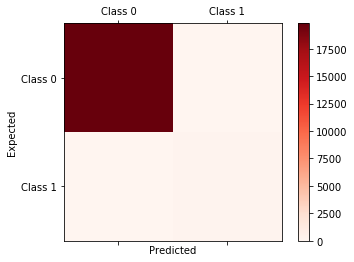

In [172]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=ytest, y_pred=ypred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Reds)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#### Random Forest Classifier

In [138]:
rand_forest = RandomForestClassifier(random_state=1, n_estimators=150)
rand_forest.fit(Xtrain,ytrain)
pred_forest = rand_forest.predict(Xtest)

Confusion matrix:
 [[19707   100]
 [    0   193]]


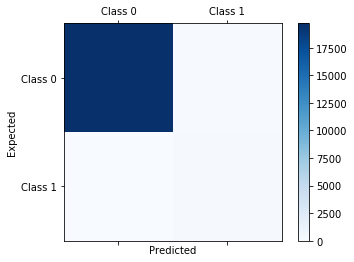

In [139]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=ytest, y_pred=pred_forest)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#### SVM seems to be overfitting the data thus Random Forest seems like a better approach

In [140]:
df['Pred'] = pred_forest

#### Using Random Forest predictions in the next part of Regression

In [141]:
#Taking a subset of data with predictions 1
df_reg = df[df['Pred'] == 1]

In [142]:
df_reg.shape

(293, 288)

In [143]:
#Taking a subset of the data with only continuous/discrete data
df_num_reg = df_reg.select_dtypes(include = ['float','int32','int64','float64','float32','uint8','int8'])
XReg = df_num_reg.drop('totals_transactionRevenue', axis=1)
XReg = XReg.drop(['visitId','Purchase','Pred'],axis=1)

yReg = df_reg[['totals_transactionRevenue']]

In [144]:
XReg.shape

(293, 207)

In [145]:
yReg.shape

(293, 1)

In [146]:
#Splitting into train ans test
from sklearn.model_selection import train_test_split

XtrainReg, XtestReg, ytrainReg, ytestReg = train_test_split(XReg, yReg, random_state=1)

In [147]:
#Running regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(XtrainReg, ytrainReg)
reg.score(XtrainReg, ytrainReg)
yPredReg = reg.predict(XtestReg)

In [148]:
ytestReg1 = ytestReg.values

In [149]:
from sklearn.metrics import r2_score
r2_score(ytestReg1,yPredReg)

0.18489708137374838

#### The model gives us a R square of 18.5% on the test data which seems like a good figure for our kind of data

#### Running the model on the entire subset of one's

In [153]:
yPredict_reg = reg.predict(XReg)

In [155]:
from sklearn.metrics import r2_score
r2_score(yReg,yPredict_reg)

0.2702568857444321

#### This gives us a R square of 27% which seems reasonable for this dataset

In [156]:
df_reg['Predicted_Values'] = yPredict_reg

C:\Users\aditi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [157]:
df_reg.columns

Index(['date', 'fullVisitorId', 'visitId', 'visitNumber', 'visitStartTime',
       'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_sessionQualityDim',
       ...
       'geoNetwork_city_Washington', 'geoNetwork_city_Wroclaw',
       'geoNetwork_city_Yokohama', 'geoNetwork_city_Zagreb',
       'geoNetwork_city_Zaragoza', 'geoNetwork_city_Zhongli District',
       'geoNetwork_city_Zurich',
       'geoNetwork_city_not available in demo dataset', 'Pred',
       'Predicted_Values'],
      dtype='object', length=289)

#### Aggregating the results

In [158]:
#Taking a subset of data with predictions 1
df_classification = df[df['Pred'] == 0]

In [159]:
df_classification.columns

Index(['date', 'fullVisitorId', 'visitId', 'visitNumber', 'visitStartTime',
       'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_sessionQualityDim',
       ...
       'geoNetwork_city_Warsaw', 'geoNetwork_city_Washington',
       'geoNetwork_city_Wroclaw', 'geoNetwork_city_Yokohama',
       'geoNetwork_city_Zagreb', 'geoNetwork_city_Zaragoza',
       'geoNetwork_city_Zhongli District', 'geoNetwork_city_Zurich',
       'geoNetwork_city_not available in demo dataset', 'Pred'],
      dtype='object', length=288)

In [160]:
df_classification['Predicted_Values'] = 0

C:\Users\aditi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Aggreagating the results from the two techniques

In [161]:
df_final = pd.concat([df_reg, df_classification], axis=0)

In [169]:
df_final.shape

(20000, 289)

In [167]:
r2_score(df_final['totals_transactionRevenue'],df_final['Predicted_Values'])

0.4073478968630866

#### The overall R square is 41%

In [168]:
np.sqrt(mean_squared_error(df_final['totals_transactionRevenue'],df_final['Predicted_Values']))

15288605.380504934

# Part 2
In this part you will create a Python function ``plot_decision_boundary`` that will accepts a machine learning model, feature set ``X``, and target set ``y`` as input and will plot the decision boundary of the input machine learning model  on ``(X,y)``. The following is a sample run of this function: 

```Python
%matplotlib inline
# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training a classifier
svm = SVC(C=0.5, kernel='linear')
svm.fit(X, y)

# Plotting decision boundary
plot_decision_boundary(X, y, clf=svm)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')```

Sample output: 
![decision_boundary.png](attachment:decision_boundary.png)

#### Defining Function 

In [173]:
def plot_decision_boundary(X, y, classifier):
    classifier.fit(X, y)
    # setup marker generator and color map
        
    markers = ('x', 'o', '^')
    colors = ('Teal','Orange','Green')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
    pass

Text(0,0.5,'petal length [cm]')

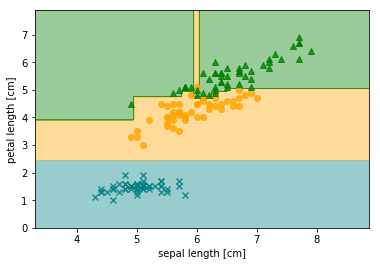

In [174]:
%matplotlib inline
# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Models
svm = SVC(C=0.5, kernel='linear')
logit = LogisticRegression(random_state=1, solver='newton-cg', multi_class='multinomial')
rand_forest = RandomForestClassifier(random_state=1, n_estimators=100)
naive = GaussianNB()
decision_tree = DecisionTreeClassifier()

# Plotting decision boundary
#Pass any one model name - svm, logit, rand_forest, naive

plot_decision_boundary(X, y, classifier=decision_tree)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')

#### SVM

Text(0.5,1,'SVM')

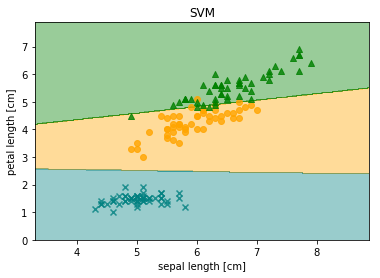

In [175]:
plot_decision_boundary(X, y, classifier=svm)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM')

#### Gaussian Naive

Text(0.5,1,'Gaussian Naive')

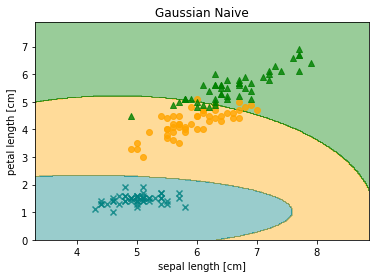

In [176]:
plot_decision_boundary(X, y, classifier=naive)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('Gaussian Naive')

#### Logistic

Text(0.5,1,'Logistic')

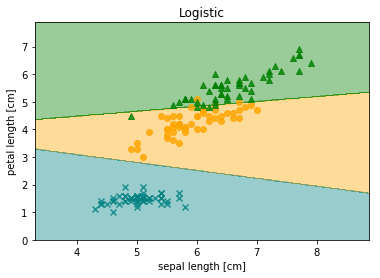

In [177]:
plot_decision_boundary(X, y, classifier=logit)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('Logistic')